In [2]:
import pandas as pd
import numpy as np
# from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
# import mdp
from datetime import datetime, timedelta
from dateutil.parser import parse
# from fbprophet import Prophet
from os import path
from scipy import signal 

from concurrent import futures
import functools

In [3]:
def read(filename, dataTypes):
    return np.genfromtxt(filename, dtype=dataTypes, delimiter=',', names=True, usecols=np.arange(0, int(len(dataTypes)))) 

In [4]:
dataTypes = ['U36', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'U36',  
    'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f',
    'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f',
    'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f',
    'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'i']

In [5]:
np_data = read("AllOldData/5_29_2021/ProcessedData/DOGE_2021-04-16.csv", dataTypes)

In [6]:
pd_data = pd.DataFrame(data=np_data, columns=np_data.dtype.names)

In [40]:
#Create hour decimal column, generated from the datetime 
pd_data["timeDecimal"] = ((pd_data.datetime.dt.hour*60+pd_data.datetime.dt.minute)*60 + pd_data.datetime.dt.second)/(60*60)

#Create a critical point column, that converts '1' and '2' (mim/max) to 'Y' for a critical point and '0' to a 'N' for Not a critical point
pd_data["criticalPoint"] = np.where(pd_data["minmax"]==0, 'N', 'Y')

In [42]:
pd_data.head(1000)[pd_data["criticalPoint"]=='Y']

<ipython-input-42-fd888f80cdd3>:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,datetime,ask_price,bid_price,mark_price,high_price,low_price,open_price,volume,datetimeNotTheIndex,mark_price_10T_velocity,...,mark_price_720T_acceleration_for_720T_velocity,mark_price_1440T_acceleration_for_1440T_velocity,mark_price_4320T_acceleration_for_4320T_velocity,mark_price_10080T_acceleration_for_10080T_velocity,mark_price_21600T_acceleration_for_21600T_velocity,min,max,minmax,timeDecimal,criticalPoint
82,2020-09-23 20:09:17.013135-05:00,0.002567,0.002563,0.002565,0.002663,0.002513,0.002622,0.0,2020-09-23 20:09:17.013135-05:00,6.000046e-07,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.002565,2,20.154722,Y
295,2020-09-23 21:20:17.139976-05:00,0.002568,0.002563,0.002565,0.002663,0.002513,0.002622,0.0,2020-09-23 21:20:17.139976-05:00,-2.000015e-07,...,NaN,NaN,NaN,NaN,NaN,0.002565,0.000000,1,21.338056,Y
329,2020-09-23 21:31:32.308420-05:00,0.002579,0.002573,0.002576,0.002663,0.002513,0.002622,0.0,2020-09-23 21:31:32.308420-05:00,8.000061e-07,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.002576,2,21.525556,Y
360,2020-09-23 21:42:02.513289-05:00,0.002569,0.002566,0.002567,0.002663,0.002513,0.002622,0.0,2020-09-23 21:42:02.513289-05:00,-7.000053e-07,...,NaN,NaN,NaN,NaN,NaN,0.002567,0.000000,1,21.700556,Y
420,2020-09-23 22:02:02.573602-05:00,0.002585,0.002582,0.002583,0.002663,0.002513,0.002622,0.0,2020-09-23 22:02:02.573602-05:00,7.000053e-07,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.002583,2,22.033889,Y
543,2020-09-23 22:43:01.907950-05:00,0.002596,0.002591,0.002593,0.002663,0.002513,0.002622,0.0,2020-09-23 22:43:01.907950-05:00,5.000038e-07,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.002593,2,22.716944,Y
596,2020-09-23 23:00:32.559794-05:00,0.002606,0.002586,0.002596,0.000000,0.000000,0.000000,0.0,2020-09-23 23:00:32.559794-05:00,1.100008e-06,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.002596,2,23.008889,Y
603,2020-09-23 23:03:02.674286-05:00,0.002602,0.002561,0.002581,0.000000,0.000000,0.000000,0.0,2020-09-23 23:03:02.674286-05:00,-2.999790e-07,...,NaN,NaN,NaN,NaN,NaN,0.002581,0.000000,1,23.050556,Y
774,2020-09-24 00:00:02.472771-05:00,0.002573,0.002568,0.002570,0.002612,0.002560,0.002590,0.0,2020-09-24 00:00:02.472771-05:00,-8.000061e-07,...,NaN,NaN,NaN,NaN,NaN,0.002570,0.000000,1,0.000556,Y


In [7]:
pd_data["datetime"] = pd.to_datetime(pd_data["datetime"])

In [8]:
pd_data.head(10)

,datetime,ask_price,bid_price,mark_price,high_price,low_price,open_price,volume,datetimeNotTheIndex,mark_price_10T_velocity,...,mark_price_60T_acceleration_for_60T_velocity,mark_price_180T_acceleration_for_180T_velocity,mark_price_720T_acceleration_for_720T_velocity,mark_price_1440T_acceleration_for_1440T_velocity,mark_price_4320T_acceleration_for_4320T_velocity,mark_price_10080T_acceleration_for_10080T_velocity,mark_price_21600T_acceleration_for_21600T_velocity,min,max,minmax
0,2020-09-23 19:42:02.537740-05:00,0.002572,0.002569,0.002570,0.002663,0.002513,0.002622,0.0,2020-09-23 19:42:02.537740-05:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,0
1,2020-09-23 19:42:17.492244-05:00,0.002573,0.002568,0.002570,0.002663,0.002513,0.002622,0.0,2020-09-23 19:42:17.492244-05:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,0
2,2020-09-23 19:42:32.484764-05:00,0.002573,0.002568,0.002570,0.002663,0.002513,0.002622,0.0,2020-09-23 19:42:32.484764-05:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,0
3,2020-09-23 19:43:02.553914-05:00,0.002575,0.002570,0.002572,0.002663,0.002513,0.002622,0.0,2020-09-23 19:43:02.553914-05:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,0
4,2020-09-23 19:43:17.510378-05:00,0.002575,0.002570,0.002572,0.002663,0.002513,0.002622,0.0,2020-09-23 19:43:17.510378-05:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,0
5,2020-09-23 19:43:32.508656-05:00,0.002573,0.002568,0.002570,0.002663,0.002513,0.002622,0.0,2020-09-23 19:43:32.508656-05:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00257,0.000000,0
6,2020-09-23 19:44:02.558631-05:00,0.002574,0.002569,0.002571,0.002663,0.002513,0.002622,0.0,2020-09-23 19:44:02.558631-05:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.002571,0
7,2020-09-23 19:44:17.486142-05:00,0.002573,0.002568,0.002570,0.002663,0.002513,0.002622,0.0,2020-09-23 19:44:17.486142-05:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,0
8,2020-09-23 19:44:32.508202-05:00,0.002572,0.002568,0.002570,0.002663,0.002513,0.002622,0.0,2020-09-23 19:44:32.508202-05:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,0
9,2020-09-23 19:45:02.552728-05:00,0.002572,0.002568,0.002570,0.002663,0.002513,0.002622,0.0,2020-09-23 19:45:02.552728-05:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,0


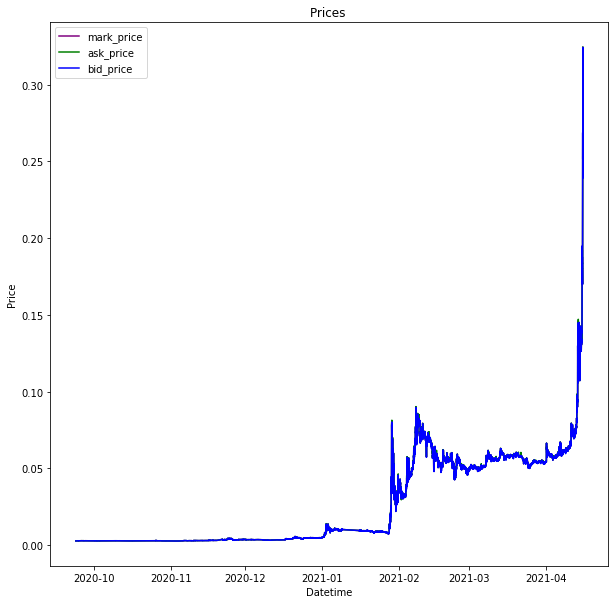

In [9]:
# sub_data = pd_data
# sub_data = pd_data.head(1000)
sub_data = pd_data.iloc[::25,:]

# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 10))

# Add x-axis and y-axis
ax.plot(sub_data['datetime'],
        sub_data['mark_price'],
        color='purple',
        label="mark_price")

# Add x-axis and y-axis
ax.plot(sub_data['datetime'],
        sub_data['ask_price'],
        color='green',
        label="ask_price")

# Add x-axis and y-axis
ax.plot(sub_data['datetime'],
        sub_data['bid_price'],
        color='blue',
        label="bid_price")

# Set title and labels for axes
ax.set(xlabel="Datetime",
       ylabel="Price",
       title="Prices ")
plt.legend()
plt.show()

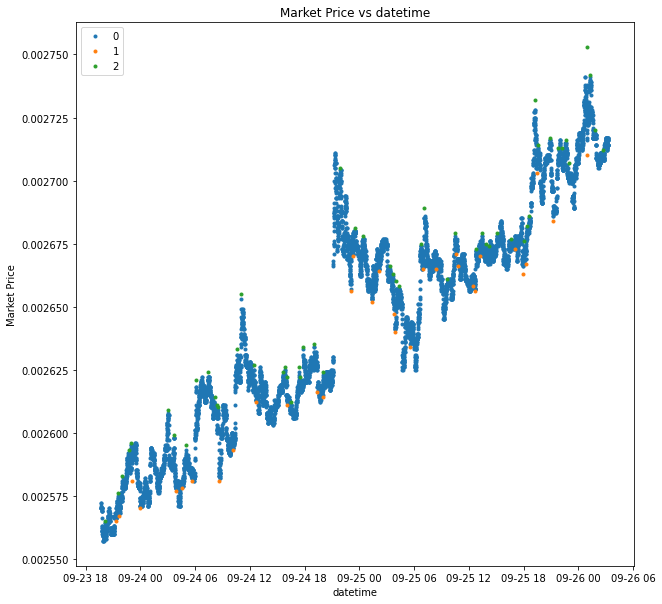

In [10]:
# sub_data = pd_data
sub_data = pd_data.head(10000)
# sub_data = pd_data.iloc[19000:20000,:]

# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 10))

# # Add x-axis and y-axis
# ax.plot(sub_data['datetime'],
#         sub_data['ask_price'],
#         color='green',
#         label="ask_price")

# # Add x-axis and y-axis
# ax.plot(sub_data['datetime'],
#         sub_data['bid_price'],
#         color='blue',
#         label="bid_price")

# Set title and labels for axes

groups = sub_data.groupby('minmax')
for name, group in groups:
    # Add x-axis and y-axis
    ax.plot(group.datetime, group.mark_price, marker='o', linestyle='', markersize=3, label=name)

ax.set(xlabel="datetime", ylabel="Market Price", title="Market Price vs datetime")

plt.legend()
plt.show()

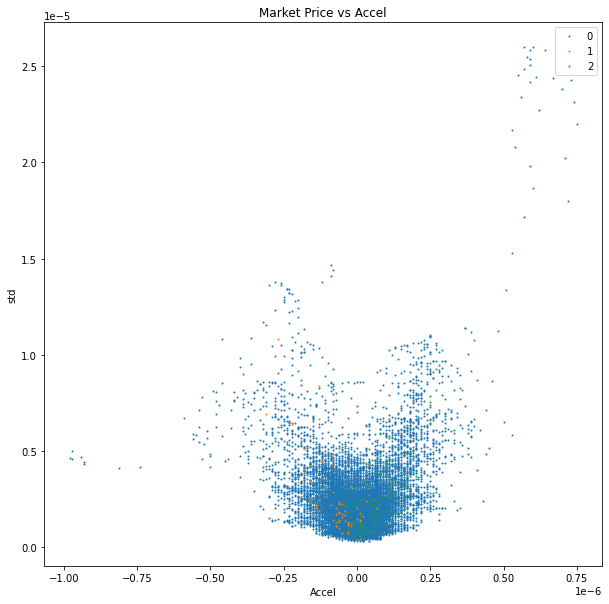

In [11]:
# sub_data = pd_data
sub_data = pd_data.head(20000)
# sub_data = pd_data.iloc[::25,:]

# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 10))

# # Add x-axis and y-axis
# ax.plot(sub_data['datetime'],
#         sub_data['ask_price'],
#         color='green',
#         label="ask_price")

# # Add x-axis and y-axis
# ax.plot(sub_data['datetime'],
#         sub_data['bid_price'],
#         color='blue',
#         label="bid_price")

# Set title and labels for axes

groups = sub_data.groupby('minmax')
for name, group in groups:
    # Add x-axis and y-axis
    ax.plot(group.mark_price_10T_acceleration_for_10T_velocity, group.mark_price_10T_std, marker='o', linestyle='', markersize=1, label=name)

ax.set(xlabel="Accel", ylabel="std", title="Market Price vs Accel")

plt.legend()
plt.show()

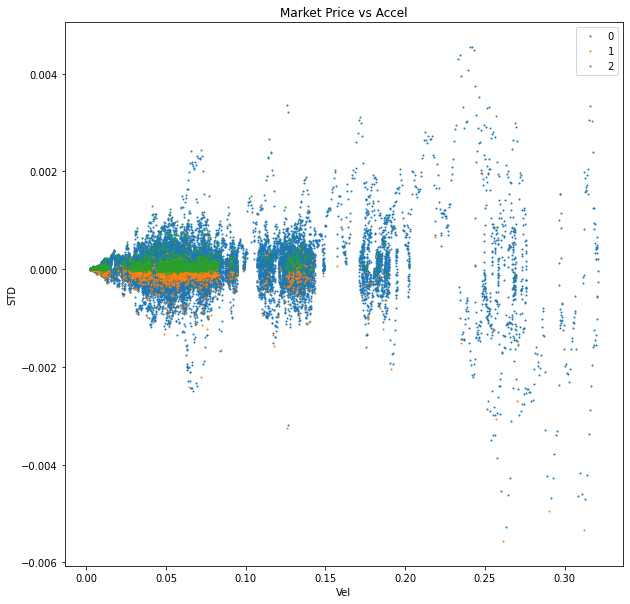

In [12]:
sub_data = pd_data
# sub_data = pd_data.head(2000)
# sub_data = pd_data.iloc[::25,:]

# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 10))

# # Add x-axis and y-axis
# ax.plot(sub_data['datetime'],
#         sub_data['ask_price'],
#         color='green',
#         label="ask_price")

# # Add x-axis and y-axis
# ax.plot(sub_data['datetime'],
#         sub_data['bid_price'],
#         color='blue',
#         label="bid_price")

# Set title and labels for axes

groups = sub_data.groupby('minmax')
for name, group in groups:
    # Add x-axis and y-axis
    ax.plot(group.mark_price_10T_mean, group.mark_price_10T_velocity, marker='o', linestyle='', markersize=1, label=name)

ax.set(xlabel="Vel", ylabel="STD", title="Market Price vs Accel")

plt.legend()
plt.show()

In [14]:
import plotly as py
import plotly.graph_objs as go
import cufflinks as cf
cf.go_offline()


In [15]:
sub_data = pd_data.head(20000)
# sub_data = pd_data
sub_data["minmax_str"] = sub_data["minmax"].apply(str)
x = "mark_price_10T_mean"
y = "mark_price_1440T_mean"
z = "mark_price_10T_velocity"
# z = "datetimeNotTheIndex"

sub_data.iplot(kind='scatter3d', x=x, y=y, z=z, mode='markers', size = 2, symbol="circle", colors=["blue", "yellow", "red"], categories='minmax_str',
xTitle = "10T_mean", yTitle = "1440T_mean", zTitle = "10T_velocity", width=0.5,margin=(0,0,0,0), opacity=0.5)

In [17]:
import sklearn.model_selection as sk_ms
from sklearn.neural_network import MLPClassifier as mlp
import sklearn.metrics

In [25]:
temp = ((pd_data.datetime.dt.hour*60+pd_data.datetime.dt.minute)*60 + pd_data.datetime.dt.second)/(60*60)
print(temp)

0          19.700556
1          19.704722
2          19.708889
3          19.717222
4          19.721389
             ...    
1052565    23.979722
1052566    23.983889
1052567    23.988056
1052568    23.992222
1052569    23.996389
Name: datetime, Length: 1052570, dtype: float64


In [43]:
trainingColumns = ['mark_price',
       'mark_price_10T_velocity', 'mark_price_60T_velocity', 'mark_price_1440T_velocity', 'mark_price_10080T_velocity',
       'mark_price_10T_mean', 'mark_price_60T_mean', 'mark_price_1440T_mean', 'mark_price_10080T_mean',
       'mark_price_10T_std', 'mark_price_60T_std', 'mark_price_1440T_std', 'mark_price_10080T_std',
       'spread',
       'mark_price_10T_acceleration_for_10T_velocity',
       'mark_price_60T_acceleration_for_60T_velocity',
       'mark_price_1440T_acceleration_for_1440T_velocity',
       'mark_price_10080T_acceleration_for_10080T_velocity',
       'timeDecimal']


X = pd_data.dropna()[trainingColumns]
Y = pd_data.dropna()["criticalPoint"]

X_train, X_test, y_train, y_test = sk_ms.train_test_split(X, Y, test_size = .33, random_state=12)
print(pd_data.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X.columns)



# Index(['datetime', 'ask_price', 'bid_price', 'mark_price', 'high_price',
#        'low_price', 'open_price', 'volume', 'datetimeNotTheIndex',
#        'mark_price_10T_velocity', 'mark_price_30T_velocity',
#        'mark_price_60T_velocity', 'mark_price_180T_velocity',
#        'mark_price_720T_velocity', 'mark_price_1440T_velocity',
#        'mark_price_4320T_velocity', 'mark_price_10080T_velocity',
#        'mark_price_21600T_velocity', 'mark_price_10T_mean',
#        'mark_price_30T_mean', 'mark_price_60T_mean', 'mark_price_180T_mean',
#        'mark_price_720T_mean', 'mark_price_1440T_mean',
#        'mark_price_4320T_mean', 'mark_price_10080T_mean',
#        'mark_price_21600T_mean', 'mark_price_10T_std', 'mark_price_30T_std',
#        'mark_price_60T_std', 'mark_price_180T_std', 'mark_price_720T_std',
#        'mark_price_1440T_std', 'mark_price_4320T_std', 'mark_price_10080T_std',
#        'mark_price_21600T_std', 'spread',
#        'mark_price_10T_acceleration_for_10T_velocity',
#        'mark_price_30T_acceleration_for_30T_velocity',
#        'mark_price_60T_acceleration_for_60T_velocity',
#        'mark_price_180T_acceleration_for_180T_velocity',
#        'mark_price_720T_acceleration_for_720T_velocity',
#        'mark_price_1440T_acceleration_for_1440T_velocity',
#        'mark_price_4320T_acceleration_for_4320T_velocity',
#        'mark_price_10080T_acceleration_for_10080T_velocity',
#        'mark_price_21600T_acceleration_for_21600T_velocity', 'min', 'max', 'timeDecimal'],
#       dtype='object')

(1052570, 51)
(642882, 19)
(642882,)
(316644, 19)
(316644,)
Index(['mark_price', 'mark_price_10T_velocity', 'mark_price_60T_velocity',
       'mark_price_1440T_velocity', 'mark_price_10080T_velocity',
       'mark_price_10T_mean', 'mark_price_60T_mean', 'mark_price_1440T_mean',
       'mark_price_10080T_mean', 'mark_price_10T_std', 'mark_price_60T_std',
       'mark_price_1440T_std', 'mark_price_10080T_std', 'spread',
       'mark_price_10T_acceleration_for_10T_velocity',
       'mark_price_60T_acceleration_for_60T_velocity',
       'mark_price_1440T_acceleration_for_1440T_velocity',
       'mark_price_10080T_acceleration_for_10080T_velocity', 'timeDecimal'],
      dtype='object')


In [20]:
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
print(imblearn.__version__)

0.8.0


In [44]:
smt = SMOTE(random_state=0)
X_train_SMOTE, y_train_SMOTE = smt.fit_resample(X_train, y_train)

In [45]:
len_of_data = len(y_train)
print(len_of_data)
strategy_over = {'Y':int(len_of_data*0.2)}
strategy_under = {'N':int(len_of_data/2)}
over = SMOTE(sampling_strategy=strategy_over)
under = RandomUnderSampler(sampling_strategy=strategy_under)

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

642882


In [46]:
X_train_SMOTE, y_train_SMOTE = pipeline.fit_resample(X_train, y_train)

In [47]:
print(len(X_train_SMOTE))
print(len(y_train_SMOTE))


print(len(y_train_SMOTE[y_train_SMOTE == 'Y']))
print(len(y_train_SMOTE[y_train_SMOTE == 'N']))

450017
450017
128576
321441


In [52]:
model = mlp(hidden_layer_sizes=(25, ), activation='relu', solver='adam', 
                                                 alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
                                                 max_iter=20000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                                                 nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                                                 n_iter_no_change=10)   
model.fit(X_train_SMOTE, y_train_SMOTE) 

MLPClassifier(hidden_layer_sizes=(25,), max_iter=20000)

In [53]:
# Evaluate on training data
print('\n-- Training data --')
predictions = model.predict(X_train)
accuracy = sklearn.metrics.accuracy_score(y_train, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_train , predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_train, predictions))
print('')


-- Training data --
Accuracy: 98.01
Classification Report:
              precision    recall  f1-score   support

           N       0.98      1.00      0.99    630701
           Y       0.04      0.00      0.00     12181

    accuracy                           0.98    642882
   macro avg       0.51      0.50      0.50    642882
weighted avg       0.96      0.98      0.97    642882

Confusion Matrix:
[[630034    667]
 [ 12151     30]]



In [54]:
# Evaluate on test data
print('\n---- Test data ----')
predictions = model.predict(X_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(y_test, predictions))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(y_test, predictions))


---- Test data ----
Accuracy: 98.03
Classification Report:
              precision    recall  f1-score   support

           N       0.98      1.00      0.99    310677
           Y       0.06      0.00      0.01      5967

    accuracy                           0.98    316644
   macro avg       0.52      0.50      0.50    316644
weighted avg       0.96      0.98      0.97    316644

Confusion Matrix:
[[310376    301]
 [  5948     19]]


In [61]:
from sklearn.linear_model import LinearRegression

print(len(y_train[y_train == 'Y']))
print(len(y_train[y_train == 'N']))

y_train_lr = np.where(y_train=='Y', 1, 0)
print(len(y_train_lr[y_train_lr == 1]))
print(len(y_train_lr[y_train_lr == 0]))

12181
630701
12181
630701


In [62]:
y_train_lr = np.where(y_train=='Y', 1, 0)
reg = LinearRegression().fit(X_train, y_train_lr)
reg.score(X_train, y_train_lr)

0.002015970723989069